# Question 1 - RNNs

In this section, you will implement a simple Recurrent Neural Network (RNN) from scratch to perform sequence prediction using the IMDb movie reviews dataset.

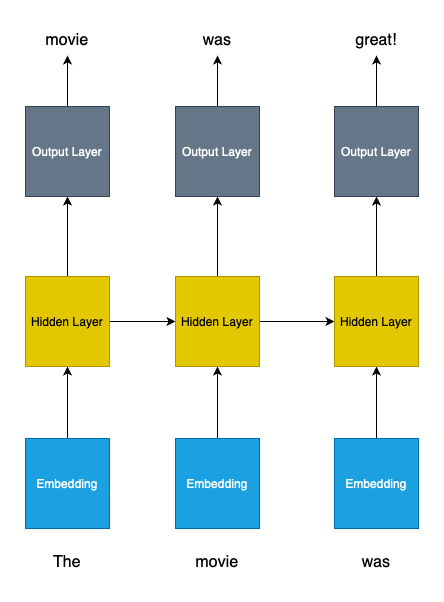

#### Importing Libraries

First we import the necessary libraries for data manipulation, model building, and training. No other libraries are allowed to be imported.

In [ ]:
import numpy as np
import gensim.downloader as api
from gensim.models import FastText, KeyedVectors
from tqdm import tqdm

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re

#### Load and Prepare Data

Next, we load the IMDb dataset and prepare it for training.

In [ ]:
vocab_size = 1000
maxlen = 100

In [ ]:
(x_train, _), (x_test, _) = imdb.load_data(num_words=vocab_size + 3, maxlen=maxlen)

In [ ]:
# Create a one-hot encoded representation of the training data
x_train_one_hot_encoded = np.zeros((x_train.shape[0], maxlen, vocab_size))

# Iterate over each sample and each word index to set the one-hot value to 1
for i in range(x_train.shape[0]):
    for j in range(len(x_train[i])):
        idx = x_train[i][j] - 3
        if idx < 0:
          idx = 0
        x_train_one_hot_encoded[i, j, idx] = 1

In [ ]:
# Decode the dataset back into words to train Word2Vec
word_index = imdb.get_word_index()
index_word = {v: k for k, v in word_index.items() if v < vocab_size}

x_train_words = [[index_word.get(idx-3, "unk") for idx in sequence] for sequence in x_train]
x_test_words = [[index_word.get(idx-3, "unk") for idx in sequence] for sequence in x_test]

In [ ]:
embedding_model = api.load("glove-twitter-50")
embedding_size = embedding_model.vector_size

In [ ]:
def embed_sequences(sequences, embedding_model, maxlen, embedding_size):
    embeddings = []
    for sequence in sequences:
        seq_embedding = [
            embedding_model[word] if word in embedding_model else np.zeros(embedding_size)
            for word in sequence
        ]
        if len(seq_embedding) < maxlen:
            # Padding with zero vectors if sequence is shorter
            seq_embedding += [np.zeros(embedding_size)] * (maxlen - len(seq_embedding))
        if len(seq_embedding) > maxlen:
            seq_embedding = seq_embedding[:maxlen]

        embeddings.append(seq_embedding)
    return np.array(embeddings)

In [ ]:
x_train_embeddings = embed_sequences(x_train_words, embedding_model, maxlen, embedding_size)
y_train_outputs = x_train_one_hot_encoded

# Get correct values for next word prediction
x_train_embeddings = x_train_embeddings[:, :maxlen - 1, :]
y_train_outputs = y_train_outputs[:, -(maxlen - 1):, :]

#### Softmax Function (2 Points)

Implement the softmax function to be used in the output layer. The fucntion should take in a one dimensional numpy array and compute softmax.

In [ ]:
def softmax(x: np.ndarray) -> np.ndarray:
    ### BEGIN IMPLEMENTATION ###
    pass

#### Input Layer Class (8 points)

Define the InputLayer class. The input player includes the following variables:   This variable represents the weight matrix connecting the input layer to the hidden layer. The dimensions are defined by the hidden size and the size of the input at each time step. It is initialized with small random values to facilitate learning during training.

Variables:
- `inputs`: The input sequences for the RNN, which are encoded using word2vec. It has a shape of (max_sequence_length, word2vec_size).
- `weights`: This weight matrix connecting the input layer to the hidden layer.
- `delta_weights`: The accumulation of the weight matrix gradients calculated across timesteps during backpropogation.

You must implement the following functions:
- `forward`: Multiply the input by the weight matrix. The output is a weighted sum that will be passed to the hidden layer for further processing. (4 points)

- `backward`: Calculate the gradient of the forward operation and add that value to `self.delta_weights`, to be updated in `update_parameters`. (4 points)



In [ ]:
class InputLayer:
    inputs: np.ndarray
    weights: np.ndarray = None
    delta_weights: np.ndarray = None

    def __init__(self, inputs: np.ndarray, hidden_size: int) -> None:
        self.inputs = inputs

        limit = np.sqrt(6 / (len(inputs[0]) + hidden_size))
        self.weights = np.random.uniform(low=-limit, high=limit, size=(hidden_size, len(inputs[0])))

        self.delta_weights = np.zeros_like(self.weights)

    def __reset_deltas__(self):
        self.delta_weights = np.zeros_like(self.weights)

    def get_input(self, time_step: int) -> np.ndarray:
        return self.inputs[time_step][:, np.newaxis]

    def forward(self, time_step: int) -> np.ndarray:
        ### BEGIN IMPLEMENTATION ###
        return self.weights @ self.get_input(time_step)
        ### END IMPLEMENTATION ###

    def backward(
        self, time_step: int, delta_weights: np.ndarray
    ) -> None:
        ### BEGIN IMPLEMENTATION ###
        pass

    def update_parameters(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.delta_weights

        self.__reset_deltas__()

#### Hidden Layer Class (8 points)

Define the HiddenLayer class. The hidden layer maintains the hidden states across time steps and computes the activations based on the weighted sum of the inputs, computed in the input layer, and the previous hidden state.

variables:
- `states`: The hidden states for all time steps during the sequence processing. It has a shape of (max_num_time_steps, hidden_size, 1).

- `weights`: The weight matrix connecting the previous hidden layer.

- `bias`: The bias vector added to the weighted sum of inputs and hidden states.

- `delta_weights`: The accumulation of gradients of the weight matrix computed during backpropogation.

- `delta_bias`: The accumulation of gradients of the bias vector computed during backpropogation.

- `next_delta_hidden_state_activation`: The gradient of the previously calculated hidden state activation.


You must implement the following functions:

- `forward`: This function computes the forward pass through the hidden layer. It combines the weighted input, the previous hidden state, and the bias, followed by applying the hyperbolic tangent activation function (tanh). The resulting activation is stored and returned for further processing. Be sure to update the hidden state using `set_hidden_state`. (4 points)

- `backward`: This function computes the gradients for backpropagation. It calculates the delta for the activation using the incoming delta_output, propagates the gradients back to the previous hidden state, and updates delta_weights and delta_bias based on the computed gradients. (4 points)

In [ ]:
class HiddenLayer:
    states: np.ndarray = None
    weights: np.ndarray = None
    delta_weights: np.ndarray = None
    bias: np.ndarray = None
    delta_bias: np.ndarray = None
    next_delta_hidden_state_activation: np.ndarray = None

    def __init__(self, max_num_time_steps: int, size: int) -> None:
        limit = np.sqrt(6 / (size + size))
        self.weights = np.random.uniform(low=-limit, high=limit, size=(size, size))

        self.bias = np.random.uniform(low=-0.1, high=0.1, size=(size, 1))
        self.states = np.zeros(shape=(max_num_time_steps, size, 1))
        self.next_delta_hidden_state_activation = np.zeros(shape=(size, 1))
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_weights = np.zeros_like(self.weights)

    def __reset_deltas__(self):
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_weights = np.zeros_like(self.weights)
        self.next_delta_hidden_state_activation = np.zeros_like(self.next_delta_hidden_state_activation)

    def __reset_states__(self):
        self.states = np.zeros_like(self.states)

    def get_hidden_state(self, time_step: int) -> np.ndarray:
            if time_step < 0:
                return np.zeros_like(self.states[0])
            return self.states[time_step]

    def set_state(self, time_step: int, prediction: np.ndarray) -> None:
        self.states[time_step] = prediction

    def forward(self, weighted_input: np.ndarray, time_step: int) -> np.ndarray:
        ### BEGIN IMPLEMENTATION ###
        pass

    def backward(
        self, time_step: int, delta_output: np.ndarray
    ) -> np.ndarray:
        ### BEGIN IMPLEMENTATION ###
        pass

    def update_parameters(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.delta_weights
        self.bias -= learning_rate * self.delta_bias

        self.__reset_deltas__()


#### Output Layer Class (8 points)

Define the OutputLayer class. The output layer will generate a probability distribution from the hidden state.

Variables:
- `states`: The computed probability distributions across all timesteps.

- `weights`: The weight matrix connecting the hidden layer.

- `bias`: The bias vector added to the output of the weighted sum.

- `delta_weights`: The accumulation of gradients of the weight matrix computed during backpropogation.

- `delta_bias`: The accumulation of gradients of the bias vector computed during backpropogation.

You must implement the following functions:
- `forward`: This function computes the forward pass through the output layer. It multiplies the hidden state by the weight matrix, adds the bias, and applies the softmax function to produce a probability distribution over the vocabulary. The resulting predictions MUST be stored using `set_prediction`. (4 points)

- `backward`: This function computes the gradients for backpropagation based on the expected outputs, updates delta_V and delta_bias with the computed gradients, and returns the propagated error to the previous layer. (4 points)


In [ ]:
class OutputLayer:
    predictions: np.ndarray = None
    weights: np.ndarray = None
    bias: np.ndarray = None
    delta_bias: np.ndarray = None
    delta_weights: np.ndarray = None

    def __init__(self, max_num_time_steps: int, size: int, hidden_size: int) -> None:
        limit = np.sqrt(6 / (size + hidden_size))
        self.weights = np.random.uniform(low=-limit, high=limit, size=(size, hidden_size))
        self.bias = np.random.uniform(low=-0.1, high=0.1, size=(size, 1))
        self.predictions = np.zeros(shape=(max_num_time_steps, size, 1))
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_weights = np.zeros_like(self.weights)

    def __reset_predictions__(self):
        self.predictions = np.zeros_like(self.predictions)

    def __reset_deltas__(self):
        self.delta_bias = np.zeros_like(self.bias)
        self.delta_weights = np.zeros_like(self.weights)

    def forward(self, hidden_state: np.ndarray, time_step: int) -> np.ndarray:
        ### BEGIN IMPLEMENTATION ###
        pass

    def get_prediction(self, time_step: int) -> np.ndarray:
        return self.predictions[time_step]

    def set_prediction(self, time_step: int, prediction: np.ndarray) -> None:
        self.predictions[time_step] = prediction

    def backward(
        self,
        expected: np.ndarray,
        hidden_state: np.ndarray,
        time_step: int,
    ) -> np.ndarray:
        ### BEGIN IMPLEMENTATION ###
        pass

    def update_parameters(self, learning_rate: float) -> None:
        self.weights -= learning_rate * self.delta_weights
        self.bias -= learning_rate * self.delta_bias

        self.__reset_deltas__()

#### RNN Class
The RNN class is a Recurrent Neural Network that combines the input, hidden, and output layers to process sequences of inputs, learn their representations, and generate predictions.

In [ ]:
from typing import List

class RNN:
    hidden_layer: HiddenLayer
    output_layer: OutputLayer
    learning_rate: float
    input_layer: InputLayer = None

    def __init__(self, vocab_size: int, hidden_size: int, max_num_time_steps: int, learning_rate: float) -> None:
        self.hidden_layer = HiddenLayer(max_num_time_steps, hidden_size)
        self.output_layer = OutputLayer(max_num_time_steps, vocab_size, hidden_size)
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

    def feed_forward(self, inputs: np.ndarray) -> OutputLayer:
        self.input_layer = InputLayer(inputs, self.hidden_size)

        for step in range(len(inputs)):
            weighted_input = self.input_layer.forward(step)
            activation = self.hidden_layer.forward(weighted_input, step)
            self.output_layer.forward(activation, step)

        return self.output_layer

    def backpropagation(self, expected: np.ndarray) -> None:
        for step_number in reversed(range(len(expected) - 1)):
            delta_output = self.output_layer.backward(
                expected[step_number],
                self.hidden_layer.get_hidden_state(step_number),
                step_number,
            )
            delta_weighted_sum = self.hidden_layer.backward(
                step_number, delta_output
            )
            self.input_layer.backward(step_number, delta_weighted_sum)


        self.output_layer.update_parameters(self.learning_rate)
        self.hidden_layer.update_parameters(self.learning_rate)
        self.input_layer.update_parameters(self.learning_rate)

    def loss(self, y_hat: List[np.ndarray], y: List[np.ndarray]) -> float:
        return -np.mean([np.sum(y[i] * np.log(y_hat[i])) for i in range(len(y))])

    def _find_end_of_seq(self, expected: np.ndarray) -> int:
        for idx, vector in enumerate(expected):
            if np.all(vector == 0):
                return idx
        return len(expected)

    def _reset_states(self):
      self.output_layer.__reset_predictions__()
      self.hidden_layer.__reset_states__()

    def train(self, inputs: np.ndarray, expected: np.ndarray, epochs: int) -> None:
        for epoch in range(epochs):
            loss_list = []
            for idx, input in enumerate(tqdm(inputs)):
                end_idx = self._find_end_of_seq(expected[idx])
                input = input[:end_idx, :]

                y_hats = self.feed_forward(input)
                self.backpropagation(expected[idx][:end_idx])

                round_loss = self.loss(y_hats.predictions[:end_idx,:,0], expected[idx][:end_idx])

                loss_list.append(round_loss)

                self._reset_states()

                if idx % 100 == 99:
                  print(f"Average Training Loss of Last 100 samples: {np.mean(np.array(loss_list[-100:]))}")

            print(
                f"Epoch Loss: {np.mean(np.array(loss_list))}"
            )


#### Running the RNN

Now we put it all together by initializing and training the RNN model. **Do not edit these hyperparameters**. Please do not change the hyperparameters. If done correctly, your loss should be below 5.0 after the second epoch.

In [ ]:
rnn = RNN(vocab_size=vocab_size, hidden_size=32, max_num_time_steps=maxlen - 1, learning_rate=1e-3)
rnn.train(x_train_embeddings, y_train_outputs, epochs=2)

# Question 2 (30 points in total)
- In this question, you will count the number of parameters in GPT-2 and trace the source code of different LLM implementations to better understand the Transformer architecture.

## Q2.1 Understand Transformer with parameter counting exercise (19 points in total)

### Let’s count the number of parameters in GPT-2-XL.
- You are only allowed to use the variable names defined below to answer the questions, i.e., `n_layers * n_heads` is allowed, while `4 * d_ffn` is not allowed.
- For simplicity, please **ignore the bias terms** in all questions.

In [ ]:
n_layers = 48  # the number of transformer layers (aka. transformer blocks)
n_heads = 25   # the number of attention heads in each layer
d_model = 1600 # the model dimension
d_ffn = 6400   # the FFN (aka. MLP) dimension
d_heads = 64   # the attn head dimension
n_vocab = 50257 # vocabulary size
n_ctx = 1024    # the maximum sequence length the model can process

#### Q2.1.1 The input embeddings consists of token embeddings (2 points) and position embeddings (2 points). Count the number of parameters in the two embeddings.

In [ ]:
token_embeddings =
print(token_embeddings)

In [ ]:
position_embeddings =  # Hint: n_ctx
print(position_embeddings)

#### Q2.1.2 Multi-Headed Attention consists of W_Q (1.5 point), W_K (1.5 point), W_V (1.5 points), and W_O (3.5 points),
- MultiHead(Q, K, V) = Concat(head_1, ..., head_n) W_O
- see more details in https://arxiv.org/pdf/1706.03762
#### Count the number of parameters in them.
- Here we * n_layers to calculate the total number of parameters across layers.

In [ ]:
attn_q = n_layers *
print(attn_q)

In [ ]:
attn_k = n_layers *
print(attn_k)

In [ ]:
attn_v = n_layers *
print(attn_v)

In [ ]:
attn_o = n_layers *
print(attn_o)

#### Q2.1.3 The feed-forward network (FFN) in each transformer block consists of two layers, ffn1 (1.5 point) and ffn2 (1.5 point). Count the number of parameters in them, respectively.
- You need to * n_layers to calculate the total number of parameters across layers.

In [ ]:
ffn1 =
print(ffn1)

In [ ]:
ffn2 =
print(ffn2)

#### Q2.1.4 Count the number of parameters in the output embeddings (2 points)

In [ ]:
output_embeddings =
print(output_embeddings)

#### Q2.1.5 Print out the total number of parameters (1 point).
- We do not double-count output_embeddings because GPT-2 shares the weights of token_embeddings and output_embeddings.
- For simplicity, we ignore the bias terms and layernorms.

In [ ]:
n_total = token_embeddings + position_embeddings + attn_q + attn_k + attn_v + attn_o + ffn1 + ffn2
print(f'{n_total/10**9:.3f}B')

#### Q2.1.6 The majority of parameters are in the FFN layers! Print the percentage (1 point).

In [ ]:
print(f'{(ffn1+ffn2)/n_total:.1%}')

## Q2.2 Understand different implementations of large language models (11 points in total)

### Different LLMs use slightly different architectures. Please read the snippets of three types of implentations below and answer the questions.
- The code is modified from Hugging Face's implementations. To answer the questions, you do not need to understand the classes and variables that are not defined in the snippets.
- `d_model`: the model dimension
- `d_ffn`: the FFN (aka. MLP) dimension

In [ ]:
%%script echo skipping
class GPT2MLP(nn.Module):
    def __init__(self, config, d_model, d_ffn):
        super().__init__()
        self.fn1 = nn.Linear(d_model, d_ffn)
        self.fn2 = nn.Linear(d_ffn, d_model)
        self.act = ACT2FN[config.activation_function]
        self.dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, hidden_states: Optional[Tuple[torch.FloatTensor]]) -> torch.FloatTensor:
        hidden_states = self.fn1(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.fn2(hidden_states)
        hidden_states = self.dropout(hidden_states)
        return hidden_states


class GPT2Block(nn.Module):
    def __init__(self, config, d_model, d_ffn, layer_idx=None):
        super().__init__()
        self.ln_1 = nn.LayerNorm(d_model, eps=config.layer_norm_epsilon)
        self.attn = GPT2_ATTENTION_CLASSES[config._attn_implementation](config=config, layer_idx=layer_idx)
        self.ln_2 = nn.LayerNorm(d_model, eps=config.layer_norm_epsilon)
        self.mlp = GPT2MLP(config, d_model, d_ffn)

    def forward(
        self,
        hidden_states: Optional[Tuple[torch.FloatTensor]],
        attention_mask: Optional[torch.FloatTensor] = None,
    ):
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        attn_output = self.attn(
            hidden_states,
            attention_mask=attention_mask,
        )
        # residual connection
        hidden_states = attn_output + residual
        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        feed_forward_hidden_states = self.mlp(hidden_states)
        # residual connection
        hidden_states = residual + feed_forward_hidden_states

        return hidden_states

skipping


In [ ]:
%%script echo skipping
class GPTJBlock(nn.Module):
    def __init__(self, config, d_model, d_ffn, layer_idx=None):
        super().__init__()
        self.ln_1 = nn.LayerNorm(d_model, eps=config.layer_norm_epsilon)
        self.attn = GPTJ_ATTENTION_CLASSES[config._attn_implementation](config, layer_idx)
        self.mlp = GPTJMLP(config, d_model, d_ffn)

    def forward(
        self,
        hidden_states: Optional[torch.FloatTensor],
        attention_mask: Optional[torch.FloatTensor] = None,
    ):
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        attn_output = self.attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
        )

        feed_forward_hidden_states = self.mlp(hidden_states)
        # residual connection
        hidden_states = attn_output + feed_forward_hidden_states + residual

        return hidden_states

In [ ]:
%%script echo skipping
class LlamaMLP(nn.Module):
    def __init__(self, config, d_model, d_ffn):
        super().__init__()
        self.gate_proj = nn.Linear(d_model, d_ffn, bias=config.mlp_bias)
        self.up_proj = nn.Linear(d_model, d_ffn, bias=config.mlp_bias)
        self.down_proj = nn.Linear(d_ffn, d_model, bias=config.mlp_bias)
        self.act_fn = ACT2FN[config.hidden_act]

    def forward(self, x):
        # x: [BS, d_model]
        hidden_states = self.act_fn(self.gate_proj(x)) * self.up_proj(x)
        output = self.down_proj(hidden_states)
        return output

#### Q2.2.1 What are the differences between `GPTJBlock()` and `GPT2Block()`? (7 points)
- Hint: (1) When do self.attn() and self.mlp() add to the residual stream, respectively? (2) What's the input of self.mlp()?
- **Ignore** the differences in bias terms, layernorm, dropout, and activation functions.

You answer here (double-clik to edit). Please explain things in Enghlish instead of Python.

#### Q2.2.2 In `LlamaMLP()`, the shape of the input `x` is `[BS, d_model]`. What are the shapes of `self.act_fn(self.gate_proj(x))`, `self.up_proj(x)`, `hidden_states`, and `output`, respectively? Answer with the variable names (4 points).
- The type of the activation function (ReLU, SiLU, or Sigmoid) does not change the answer

#### Your answer here
- (1 point) The shape of the output of `self.act_fn(self.gate_proj(x))`:
- (1 point) The shape of the output of `self.up_proj(x)`:
- (1 point) The shape of `hidden_states`:
- (1 point) The shape of `output`:

# Question 3: Finetuning

In this question, you will be asked to finetune a pretrained language model DistillBERT on sentiment analysis task using IMDb dataset.

In [ ]:
!pip install datasets

In [ ]:
#load dataset
# we use imdb dataset to finetune the model. We test the model on imdb and sst2.
from datasets import load_dataset

imdb_dataset = load_dataset('stanfordnlp/imdb')


## 1. Preprocess the data (4pts)


For imdb, split the train dataset into train set and dev set. The dev set is used within training process to select the best checkpoint. Use train_test_split() from sklearn to split. The ratio of dev set is 0.1. Set the random state as 42.

In [ ]:
from sklearn.model_selection import train_test_split
# write your code here, make sure you use the name defined below.




In [ ]:
print(train_x[0])

"Algie, the Miner" is one bad and unfunny silent comedy. The timing of the slapstick is completely off. This is the kind of humor with certain sequences that make you wonder if they're supposed to be funny or not. However, the actual quality of the film is irrelevant. This is mandatory viewing for film buffs mainly because its one of the earliest examples of gay cinema. The main character of Algie is an effeminate guy, acting much like the stereotypical "pansy" common in many early films. The film has the homophobic attitude common of the time. "Algie, the Miner" is pretty awful, but fascinating from a historical viewpoint. (3/10)


## 2. Prepare the data (10pts)


We use Dataset class from torch.utils.data to prepare data, and DataLoader class to prepare batches for training.

In the SentimentAnalysisDataset class, you need to use DistillBert tokenizer to tokenize the sentence.

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from torch.utils.data import Dataset, DataLoader

import torch


class SentimentAnalysisDataset(Dataset):
  #write your code here
  def __init__(self,data, tokenizer, max_len = 512):



  def prepare(self):


  def __len__(self):
    return self.len

  def __getitem__(self,idx):


# Example of usage
# Usage of GPU: due to limit usage of GPU on Colab, we will not train the whole training set. If you can get access to GPU, we strongly recommend you to run it on GPU and try it on the whole dataset. In this homework, we only run first 20 samples.
train = {'input':train_x[:20], 'label':train_y[:20]}
train_dataset = SentimentAnalysisDataset(train, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True)


torch.Size([20, 512])


In [ ]:
assert sum(train_dataset.attention_masks[0])==149

## 3. Define the model (12pts)

We use DistillBERT as base model. We still need a linear layer to mapping the last hidden state to classes dimension.

The model should have a base model, a linear layer, a dropout layer (0.5) and softmax function. The forward function go through all the layers one by one and return the softmax result.

In [ ]:
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bertmodel = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")

class ClassificationModel(nn.Module):
    def __init__(self,base_model,num_classes):
        super().__init__()
        #write your code here


    def forward(self,input_ids, attention_mask):
        #write your code here

        return predicts

In [ ]:
model = ClassificationModel(base_model = bertmodel, num_classes = 2 )

In [ ]:
#test case
input_ids = train_dataset.input_ids[0]
attention_mask = train_dataset.attention_masks[0]
model.eval()
with torch.no_grad():
  predicts = model(input_ids,attention_mask)


In [ ]:
assert predicts.tolist() == [[0.5158617496490479, 0.48413828015327454]]

## 4. Model finetuning (10pts)

In this section, you need to implement train loop and evaluation loop.

 Initialize the optimizer. We use AdamW for optimizer and cross entropy loss. (3pts)

In [ ]:
# write your code here



We use pytorch to implement. For each epoch, we run one training loop and one evaluation loop. At the end of training, we run the model on test set using the best model saved. For one training step, we run forward pass using pretrained model given input. Then we calculate loss and do backward propagation. See the instructions in the code block.  (7pts)

Ideally, you should see a obvious decrease (0.7-1) in train loss, but no decrease in dev loss, since the model is overfitting on a small training set.


In [ ]:
from tqdm import tqdm
epochs = 10 # don't change

num_training_steps = epochs * len(train_dataloader)
best_model = None
with tqdm(total=num_training_steps, desc='Finetuning:') as pbar:
  for epoch in range(epochs):
    # training loop
    model.train()
    train_loss = 0
    for batch in train_dataloader:
      '''
      Tips:
      1. Put the input and model on the same device
      2. Use the optimizer correctly
      3. Update the train loss. The printed train loss should be train_loss/len(train_dataloader)
      '''
      # write your code here

    print(f'Epoch {epoch}: train loss is {train_loss}')
    best_loss = 10000
    model.eval()
    with torch.no_grad():
      for batch in dev_dataloader:

        dev_loss = 0
        '''
        Tips:
        1. You don't need to use optimizer
        2. Update the dev loss. The printed dev loss should be dev_loss/len(dev_dataloader)
        3. Save the checkpoint if the dev loss is smaller than best loss and update the best loss to dev loss
        '''

      print(f'Epoch {epoch}: dev loss is {dev_loss}')
      if dev_loss < best_loss:
        #save the checkpoint
        # write your code here
        print(f'The best loss is {dev_loss}. Saving checkpoint!')





